## Analysing Self Loops
Analyse the magnitude of self loops during different parts of restrictions (e.g. during lockdowns and during free movement) to get a proxy for the overall movement within towns and therefore scale delta based on this when simulating the outbreak with a lockdown

In [1]:
# Import those libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time
from operator import add
from scipy.stats import binom
from numpy import random
from joblib import Parallel, delayed
import collections
import csv
from scipy.optimize import curve_fit

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
waloc = pd.read_csv('/Users/Yuval/Desktop/Thesis/all-wa-pos.csv')#use this for all 297 towns
waloc = waloc.loc[waloc['Population'] >0]
# When doing big towns
waloc = waloc[:58]

# When ignoring sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Yanchep') & (waloc['City / Town'] != 'Bullsbrook') &
                  (waloc['City / Town'] != 'Mundijong') & (waloc['City / Town'] != 'Serpentine') &
                 (waloc['City / Town'] != 'Two Rocks') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring rural sattelite towns
waloc = waloc.loc[(waloc['City / Town'] != 'Pinjarra') & (waloc['City / Town'] != 'Drummond Cove') &
                  (waloc['City / Town'] != 'Bridgetown') & (waloc['City / Town'] != 'Binningup') &
                 (waloc['City / Town'] != 'Dampier') ]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

# When also ignoring 0 flow towns
waloc = waloc.loc[(waloc['City / Town'] != 'Kununurra') & (waloc['City / Town'] != 'Derby') &
                  (waloc['City / Town'] != 'Boddington-Ranford') & (waloc['City / Town'] != 'Wyndham')]
waloc = waloc.reset_index()
waloc = waloc.drop(columns = ['index'])

towns = list(waloc['City / Town'])

In [4]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
st = os.listdir("/Volumes/HardDrive/New_Workflow/44_self_loops")

stoch = []
for i in st:
    if '._' not in i:
        stoch.append(i)
        
d = {}
for i in range(len(stoch)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/New_Workflow/44_self_loops/"+stoch[i], header = None, sep =',')

In [5]:
byweek = []
for i in range(len(d)):
    bytown = []
    for town in range(44):
        bytown.append(d[str(i)][town][town])
    byweek.append(bytown)

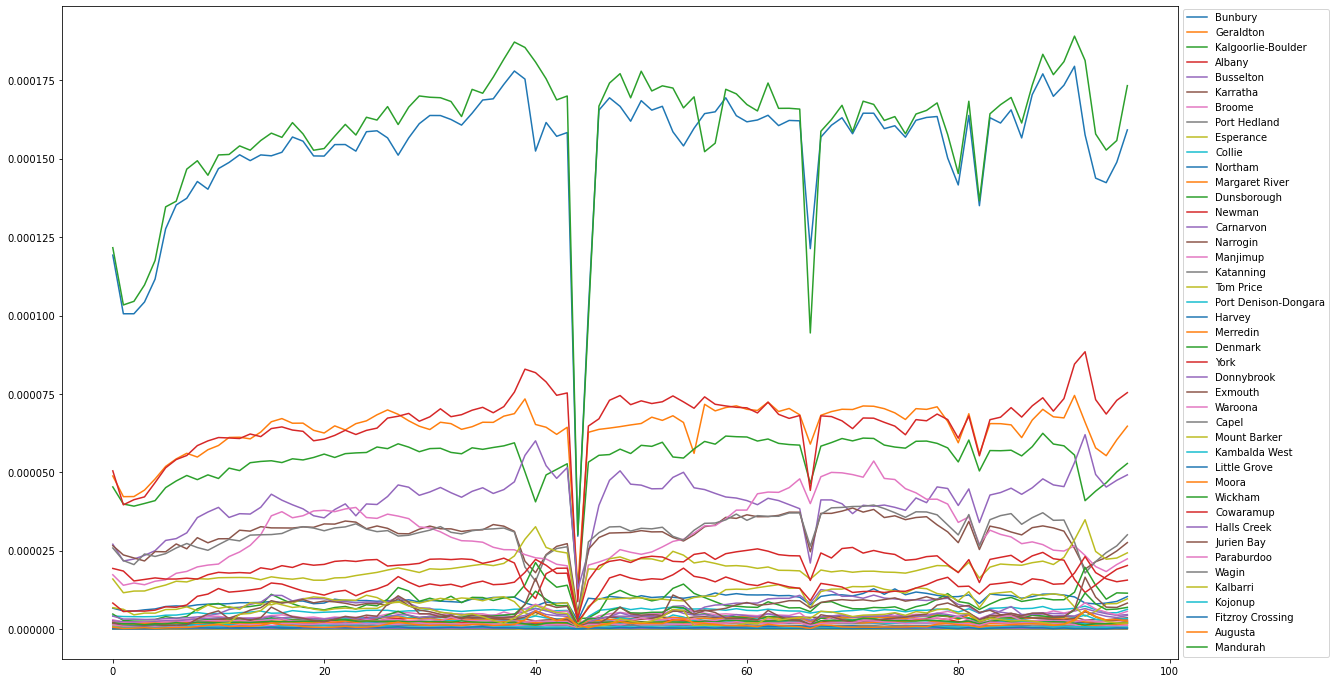

In [6]:
allweeks = list(zip(*byweek))
towns = list(waloc['City / Town'])
plt.figure(figsize = (20,12))
#plt.ylim(0,0.00000002)
for i in range(1,len(allweeks)):
    plt.plot(allweeks[i], label = towns[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
months = []
for name in stoch:
    m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    mo = int(name[14:16])
    ye = int(name[12:14])
    
    date = str(m[mo-1]) + ' ' + str(ye)
    if date in months:
        months.append('')
    else:
        months.append(date)

In [10]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

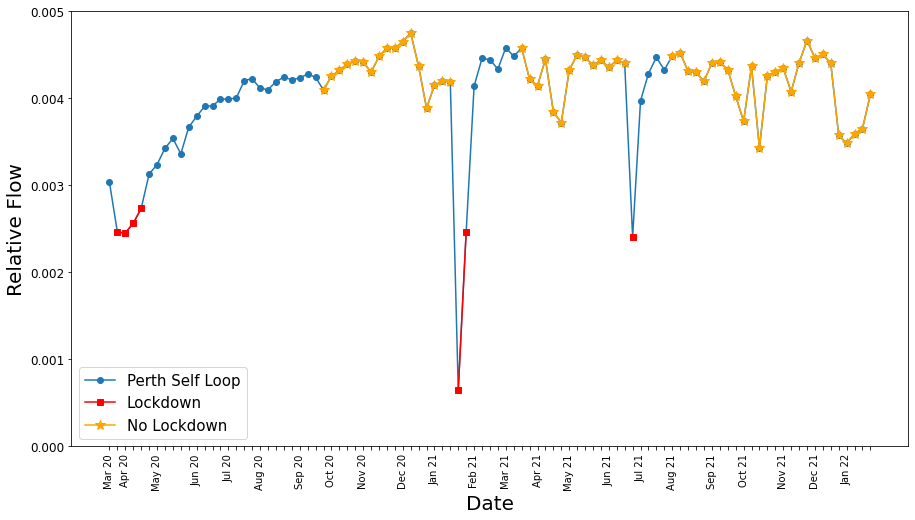

In [12]:
allweeks = list(zip(*byweek))
towns = list(waloc['City / Town'])
#allweeks[0] = [i * 9*10**9 for i in allweeks[0]]
plt.figure(figsize = (15,8))
plt.plot(allweeks[0], marker = 'o', label = 'Perth Self Loop')
plt.plot([i for i in range(1,5)], allweeks[0][1:5],marker = 's', color = 'red', label = 'Lockdown')
plt.plot([i for i in range(44,46)], allweeks[0][44:46],marker = 's', color = 'red')
plt.plot([i for i in range(66,67)], allweeks[0][66],marker = 's', color = 'red')
plt.plot([i for i in range(27,44)], allweeks[0][27:44], marker = '*', ms = 11, color = 'orange', label = 'No Lockdown')
plt.plot([i for i in range(52,66)], allweeks[0][52:66], marker = '*', ms = 11, color = 'orange')
plt.plot([i for i in range(71,97)], allweeks[0][71:97], marker = '*', ms = 11, color = 'orange')
plt.ylim(0,0.005)
plt.xticks([i for i in range(97)],months,rotation = 90,fontsize = 10)
plt.ylabel('Relative Flow', fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.legend(fontsize = 15)

In [10]:
min([i * 9*10**9 for i in allweeks[0]])

5821363.5628878

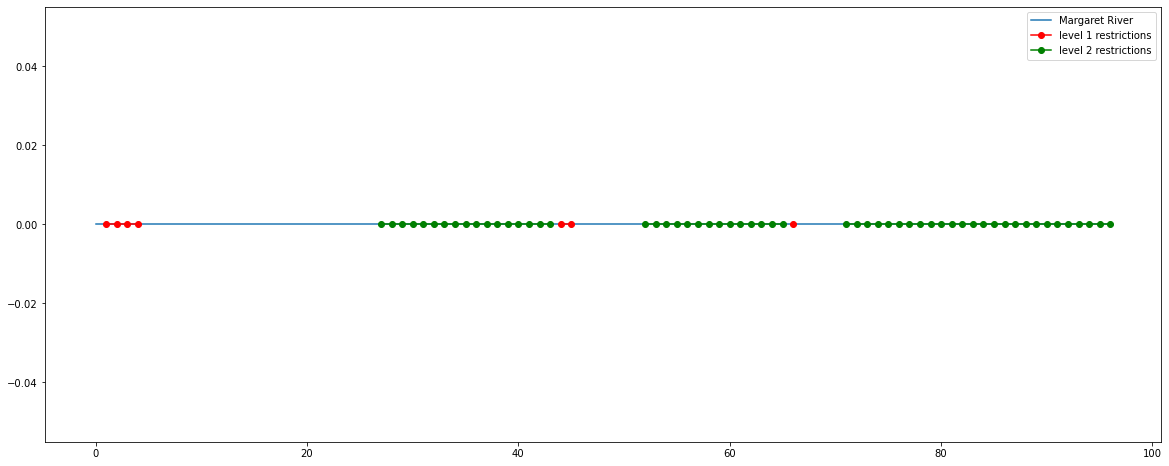

In [66]:
allweeks = list(zip(*byweek))
towns = list(waloc['City / Town'])
plt.figure(figsize = (20,8))
plt.plot(allweeks[12], label = towns[12])
plt.plot([i for i in range(1,5)], allweeks[12][1:5],marker = 'o', color = 'red', label = 'level 1 restrictions')
plt.plot([i for i in range(44,46)], allweeks[12][44:46],marker = 'o', color = 'red')
plt.plot([i for i in range(66,67)], allweeks[12][66],marker = 'o', color = 'red')
plt.plot([i for i in range(27,44)], allweeks[12][27:44], marker = 'o', color = 'green', label = 'level 2 restrictions')
plt.plot([i for i in range(52,66)], allweeks[12][52:66], marker = 'o', color = 'green')
plt.plot([i for i in range(71,97)], allweeks[12][71:97], marker = 'o', color = 'green')
plt.legend()

In [69]:
ratio = []
for i in range(44):
    lock = np.mean(list(allweeks[i][1:5]) + list(allweeks[i][44:46]) + [allweeks[i][66]])
    free = np.mean(allweeks[i][27:44] + allweeks[i][52:66] + allweeks[i][71:97])
    ratio.append(free/lock)
    print(" {:20s} {:.3f}".format(towns[i], free / lock))

 Perth                1.895
 Bunbury              1.689
 Geraldton            1.494
 Kalgoorlie-Boulder   1.454
 Albany               1.718
 Busselton            2.076
 Karratha             1.473
 Broome               1.859
 Port Hedland         1.528
 Esperance            1.692
 Collie               1.698
 Northam              1.587
 Margaret River       nan
 Dunsborough          2.903
 Newman               1.478
 Carnarvon            1.883
 Narrogin             1.428
 Manjimup             2.090
 Katanning            1.479
 Tom Price            1.953
 Port Denison-Dongara 2.404
 Harvey               1.636
 Merredin             1.649
 Denmark              2.679
 York                 1.779
 Donnybrook           2.178
 Exmouth              2.799
 Waroona              1.699
 Capel                1.584
 Mount Barker         nan
 Kambalda West        1.801
 Little Grove         1.654
 Moora                1.308
 Wickham              1.611
 Cowaramup            2.581
 Halls Creek          1.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [75]:
towns.index('Albany')

4

In [74]:
ratio[29]

nan

In [78]:
# Make nan towns the same as close by towns
ratio[12] = ratio[34] # Margs = cowaramup
ratio[29] = ratio[4] #Mt Barker = Albany
ratio = [ratio]
ratio

[[1.8946333742843646,
  1.6887479712255724,
  1.4938295548360883,
  1.4539201620304343,
  1.7181931847547278,
  2.076423694040011,
  1.4726012367106749,
  1.8590633308817057,
  1.5276624355334398,
  1.6921080260822332,
  1.698253335206962,
  1.587377567412233,
  2.5812454094638464,
  2.9026679795903827,
  1.4783968693503615,
  1.8828242197312262,
  1.4278378540218797,
  2.0904490347889153,
  1.47894477164698,
  1.953391828197826,
  2.403521180507083,
  1.6359213211314325,
  1.6488591806161448,
  2.6785068627681965,
  1.7788967203017985,
  2.1780836351203416,
  2.799407211653901,
  1.6987159187962422,
  1.5836981992445642,
  1.7181931847547278,
  1.8009594156610904,
  1.654025289498336,
  1.3084067965533661,
  1.6112606367068343,
  2.5812454094638464,
  1.2195986605875078,
  5.304264720395842,
  2.0111416205809722,
  1.5715726384356143,
  4.606619989477246,
  1.5226261022765917,
  2.0350424896236317,
  3.910842898678582,
  1.7866652016454643]]

In [79]:
with open("/Volumes/HardDrive/New_Workflow/44_self_loop_ratio/ratio_44.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(ratio)

In [68]:
# for i in range(44):
#     lock = np.mean([allweeks[i][44]] + [allweeks[i][66]])
#     #lock = allweeks[i][44]
#     free = np.mean(allweeks[i][27:44] + allweeks[i][52:66] + allweeks[i][71:97])
#     print(" {:20s} {:.3f}".format(towns[i], free / lock))